Using data around the ATLAS stream, try to improve star-galaxy separation

In [5]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.stats import binned_statistic

from galstreams import MWStreams
streams = MWStreams(verbose=0)

In [8]:
stream = streams['ATLAS']
stream_fr = stream.gcfr

In [12]:
def ps1_to_decals(g, r, i, z):
    g_dec = (g + 0.00062 + 0.03604*(g - i) + 
             0.01028*(g - i)**2 - 0.00613*(g - i)**3)
    r_dec = (r + 0.00495 - 0.08435*(g - i) + 
             0.03222*(g - i)**2 - 0.01140*(g - i)**3)
    z_dec = (z + 0.02583 - 0.07690*(g - i) + 
             0.02824*(g - i)**2 - 0.00898*(g - i)**3)
    return g_dec, r_dec, z_dec

In [38]:
t = at.Table.read('../data/atlas_ls_dr8.fits.gz')
init_mask = (t['snr_g'] > 1) & (t['snr_r'] > 1) & (t['snr_z'] > 1)
t = t[init_mask]
len(t)

991264

In [39]:
g = t['dered_mag_g']
r = t['dered_mag_r']
z = t['dered_mag_z']
gr = g - r
rz = r - z

err_g = 1 / t['snr_g']
err_r = 1 / t['snr_r']
err_z = 1 / t['snr_z']

In [40]:
t_c = coord.SkyCoord(t['ra']*u.deg, t['dec']*u.deg)
t_fr = t_c.transform_to(stream_fr)

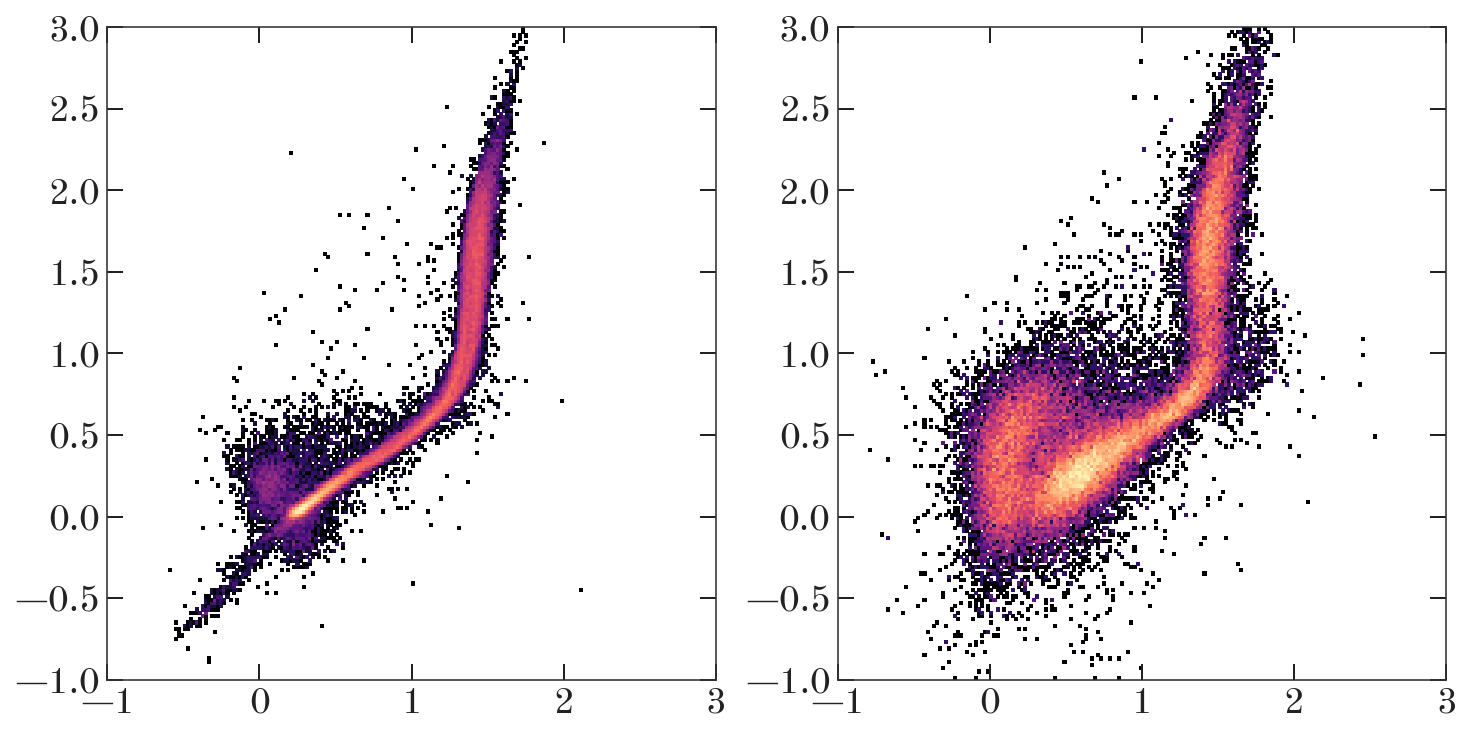

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
mask = (g > 19) & (g < 21)
ax.hist2d(gr[mask], 
          rz[mask],
          bins=np.arange(-1, 3+1e-3, 0.02),
          norm=mpl.colors.LogNorm());

ax = axes[1]
mask = (g > 23) & (g < 23.5)
ax.hist2d(gr[mask], 
          rz[mask],
          bins=np.arange(-1, 3+1e-3, 0.02),
          norm=mpl.colors.LogNorm());

(-1, 3)

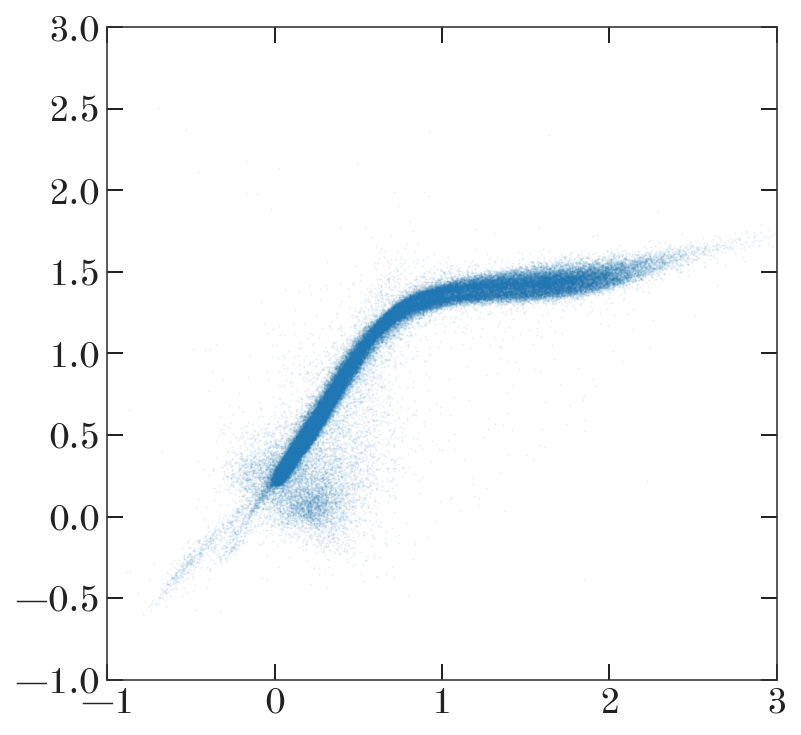

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
mask = (g > 15) & (g < 21.5)
ax.plot(rz[mask], gr[mask],
        marker='o', ls='none', mew=0, ms=1., alpha=0.1)
ax.set_xlim(-1, 3)
ax.set_ylim(-1, 3)

In [43]:
from scipy.interpolate import interp1d

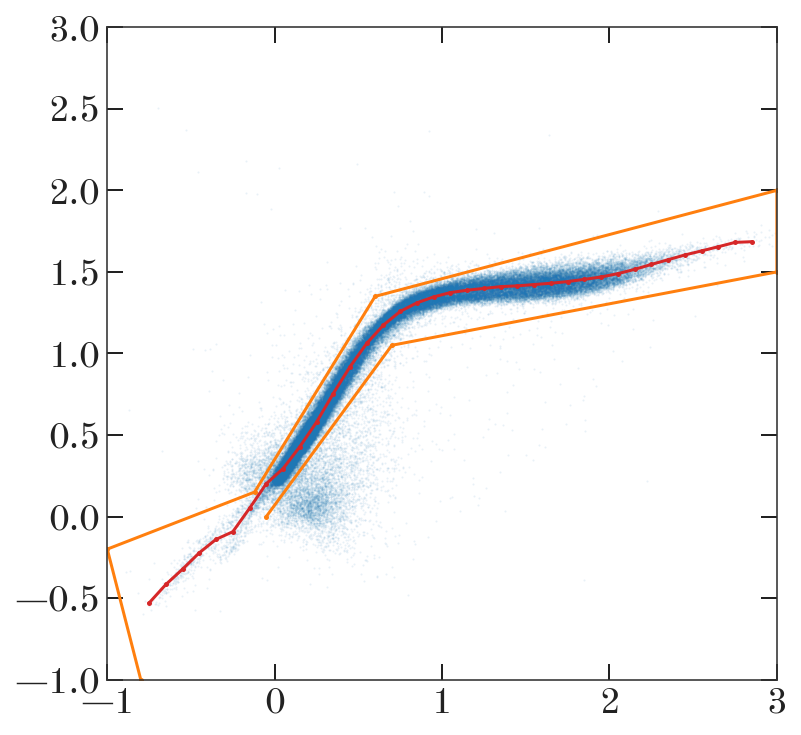

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
mask = (g > 15) & (g < 21.5)
# mask = (g > 22) & (g < 23)
ax.plot(rz[mask], gr[mask],
        marker='o', ls='none', mew=0, ms=1., alpha=0.1)

ax.set_xlim(-1, 3)
ax.set_ylim(-1, 3)

poly_nodes = np.array([[-0.05, 0],
                       [0.7, 1.05],
                       [3, 1.5],
                       [3, 2],
                       [0.6, 1.35],
                       [-0.12, 0.15],
                       [-1,-0.2],
                       [-0.8, -1]])
ax.plot(poly_nodes[:, 0], poly_nodes[:, 1])
poly_mask = mpl.path.Path(poly_nodes).contains_points(
    np.stack((rz, gr)).T)

stat = binned_statistic(rz[mask & poly_mask], 
                        gr[mask & poly_mask],
                        bins=np.arange(-1, 3, 0.1),
                        statistic='median')
bin_ctr = 0.5 * (stat.bin_edges[:-1] + stat.bin_edges[1:])

# HACK:
x = bin_ctr[2:]
y = stat.statistic[2:]
# x = np.concatenate(([-0.7, -0.15, 0.1], bin_ctr[6:]))
# y = np.concatenate(([-0.5, 0., 0.32], stat.statistic[6:]))
sl_interp = interp1d(x, y, kind='cubic', bounds_error=False)
ax.plot(x, y,
        color='tab:red')

(-1, 3)

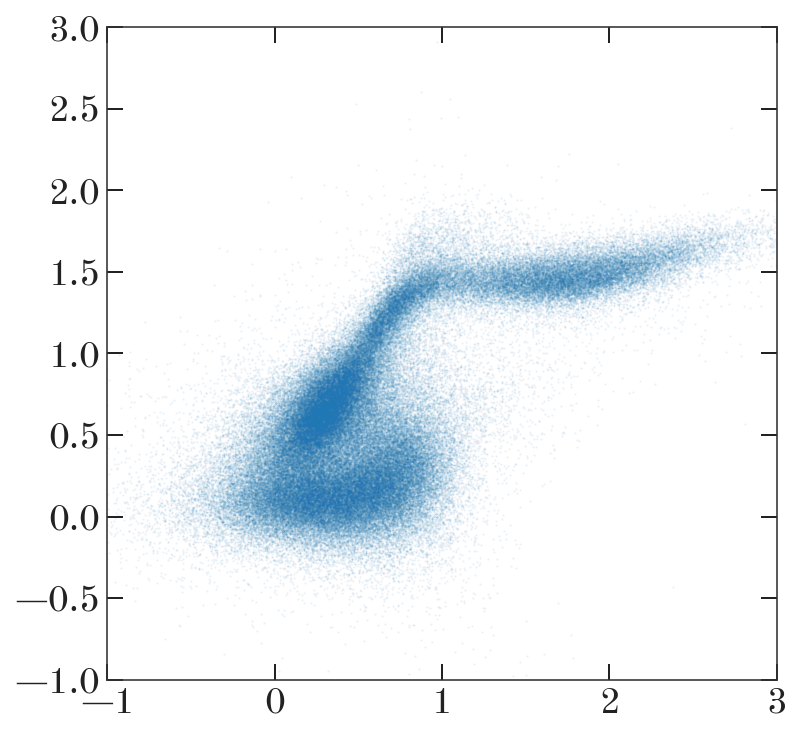

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# mask = (g > 15) & (g < 21.5)
mask = (g > 23) & (g < 24)
ax.plot(rz[mask], gr[mask],
        marker='o', ls='none', mew=0, ms=1., alpha=0.1)

ax.set_xlim(-1, 3)
ax.set_ylim(-1, 3)

In [46]:
def get_smudge(g):
    if g < 22:
        return 0.08
    else:
        return 0.05/2*(g - 22) + 0.08

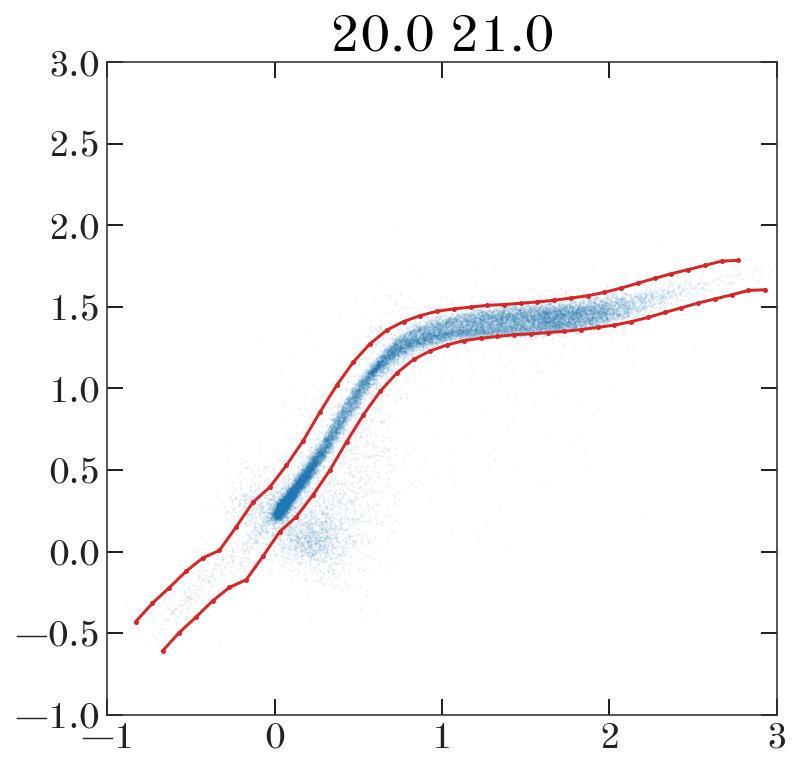

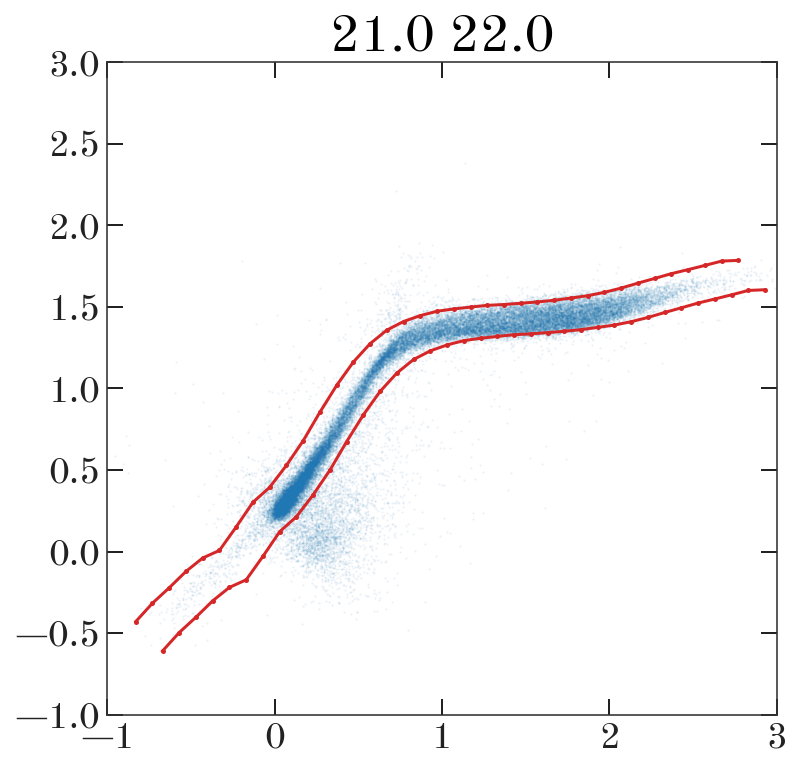

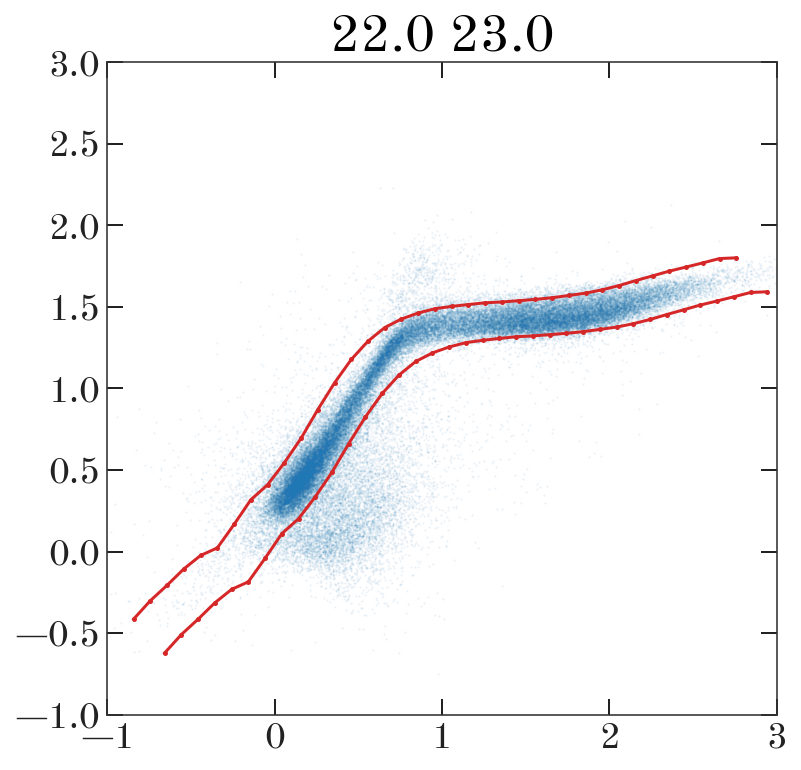

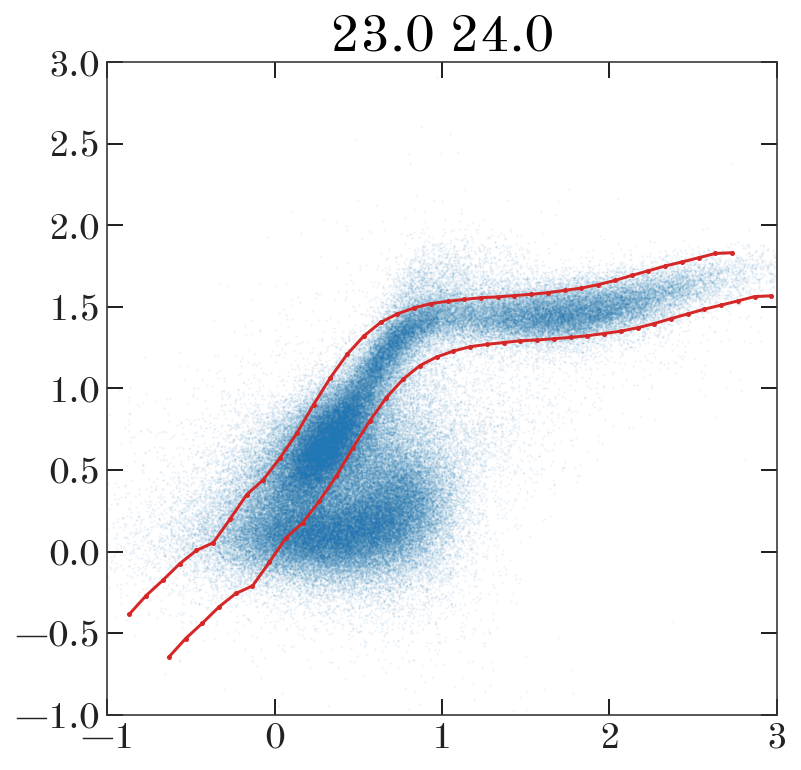

In [47]:
gbins = np.arange(20, 24+1e-3, 1)
for _l, _r in zip(gbins[:-1], gbins[1:]):
    mask = (g > _l) & (g < _r)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    ax.plot(rz[mask], gr[mask],
            marker='o', ls='none', mew=0, ms=1., alpha=0.1)
    
    sm = get_smudge(0.5 * (_l+_r))
    ax.plot(x - sm, y + 1.25*sm,
            color='tab:red')
    ax.plot(x + sm, y - sm,
            color='tab:red')
    ax.set_xlim(-1, 3)
    ax.set_ylim(-1, 3)
    
    ax.set_title(f'{_l:.1f} {_r:.1f}')

In [48]:
iso = at.Table.read('/Users/apricewhelan/data/Isochrones/MIST/FeH_-1.8_iso.fits')

In [49]:
iso = iso[iso['log10_isochrone_age_yr'] == 10]
iso = iso[iso['phase'] < 2]

(24, 15)

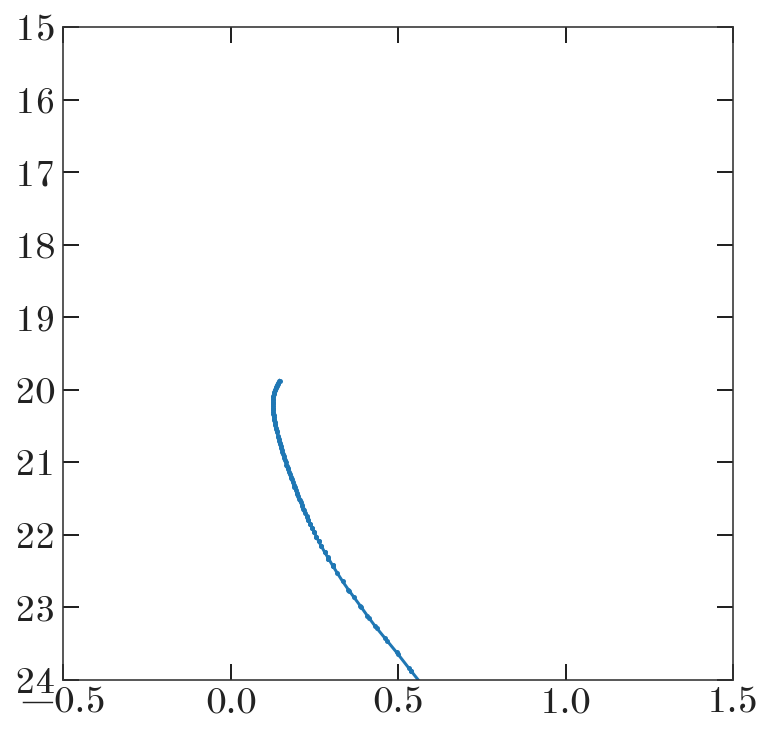

In [50]:
dm = coord.Distance(20*u.kpc).distmod.value

plt.figure(figsize=(6, 6))
plt.plot(iso['ps1_g'] - iso['ps1_r'],
         iso['ps1_g'] + dm)
plt.xlim(-0.5, 1.5)
plt.ylim(24, 15)

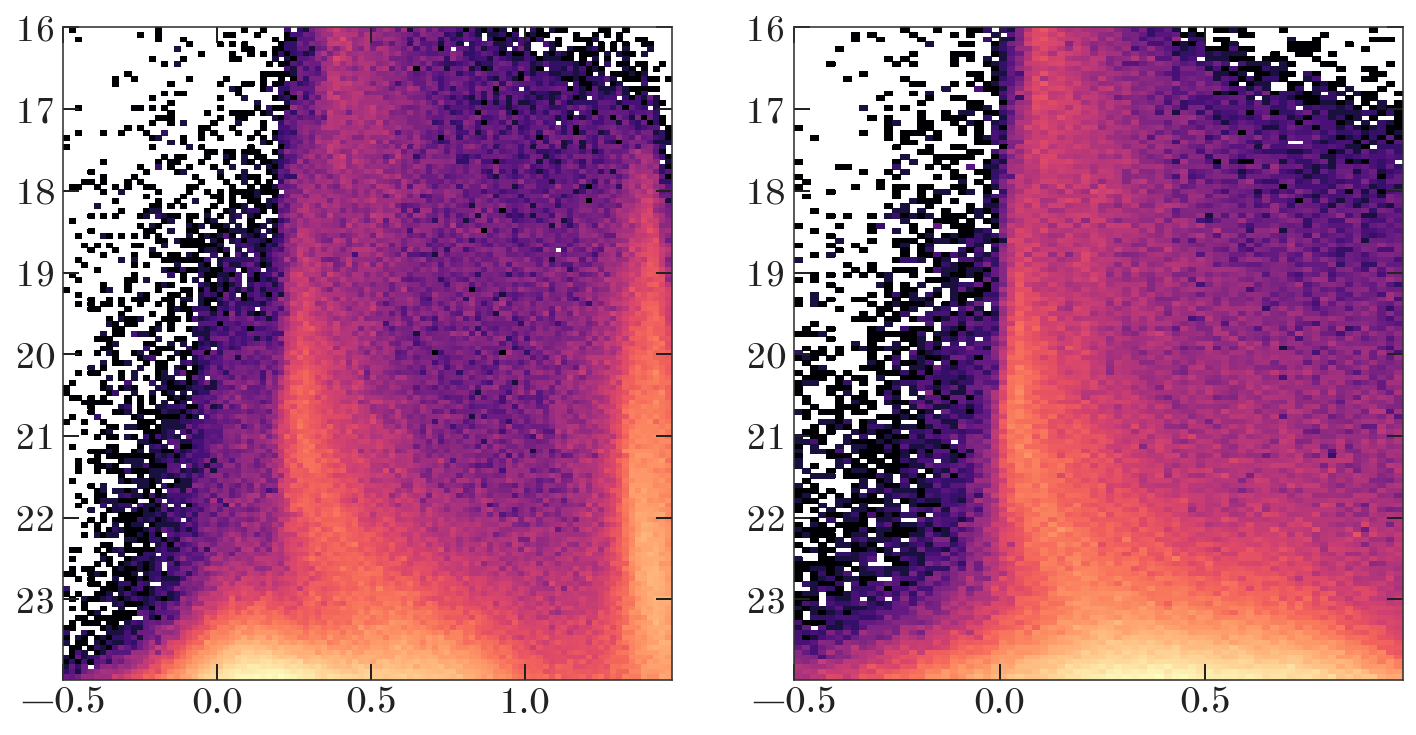

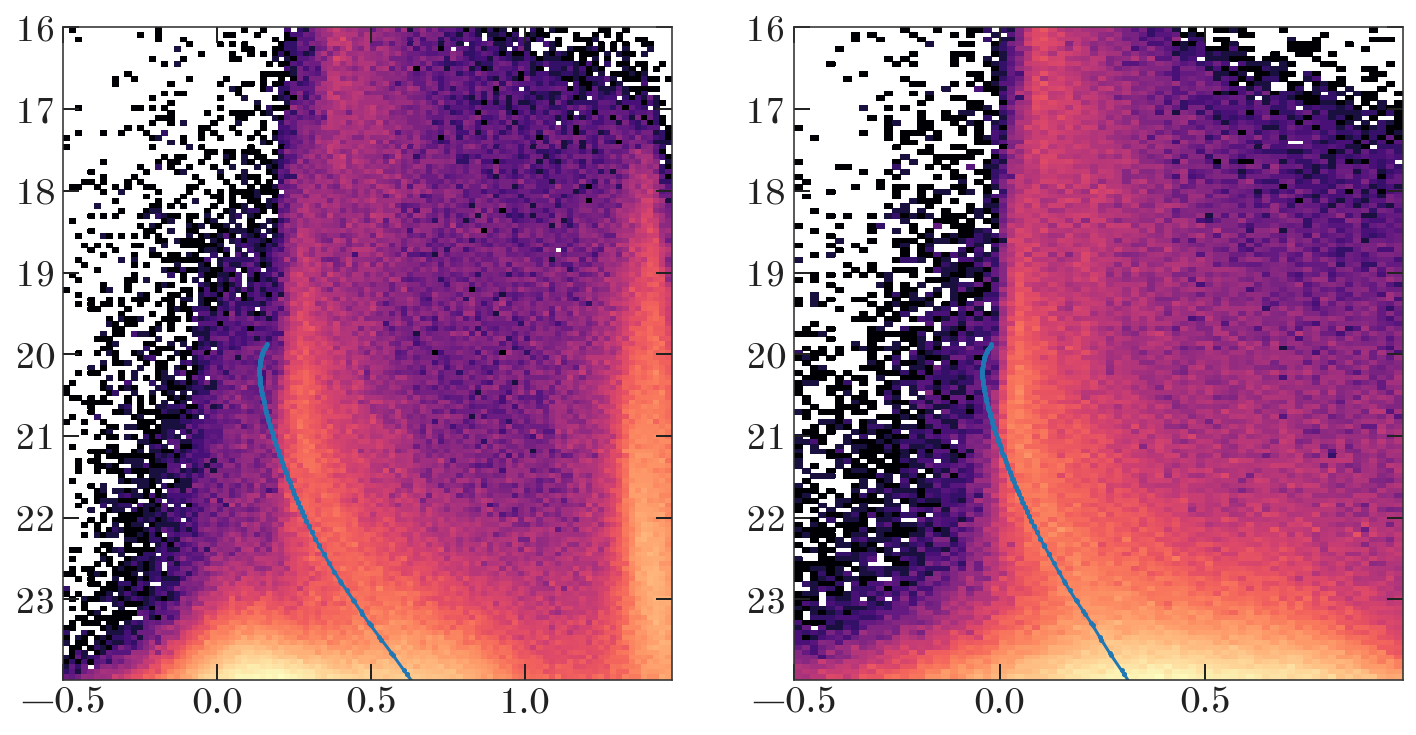

In [51]:
iso_grz = ps1_to_decals(iso['ps1_g'], iso['ps1_r'], iso['ps1_i'], iso['ps1_z'])

for i in range(2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    ax = axes[0]
    ax.hist2d(gr, g,
              bins=(np.arange(-0.5, 1.5, 0.02),
                    np.arange(16, 24+1e-3, 0.06)),
              norm=mpl.colors.LogNorm());
    if i > 0:
        ax.plot(iso_grz[0] - iso_grz[1],
                iso_grz[0] + dm)
    ax.set_ylim(ax.get_ylim()[::-1])

    ax = axes[1]
    ax.hist2d(rz, g,
              bins=(np.arange(-0.5, 1., 0.02),
                    np.arange(16, 24+1e-3, 0.06)),
              norm=mpl.colors.LogNorm());
    if i > 0:
        ax.plot(iso_grz[1] - iso_grz[2],
                iso_grz[0] + dm)
    ax.set_ylim(ax.get_ylim()[::-1])

In [52]:
grg_interp = interp1d(iso_grz[0] + dm,
                      iso_grz[0] - iso_grz[1],
                      bounds_error=False)
rzg_interp = interp1d(iso_grz[0] + dm,
                      iso_grz[1] - iso_grz[2],
                      bounds_error=False)

In [53]:
gr_sqdiff = (gr - grg_interp(g))**2 / (err_g**2 + err_r**2 + 0.02**2)
rz_sqdiff = (rz - rzg_interp(g))**2 / (err_r**2 + err_z**2 + 0.02**2)

sqdiff = gr_sqdiff + rz_sqdiff
sqdiff_mask = (np.sqrt(sqdiff) < 2.)

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


(23.97999999999983, 16.0)

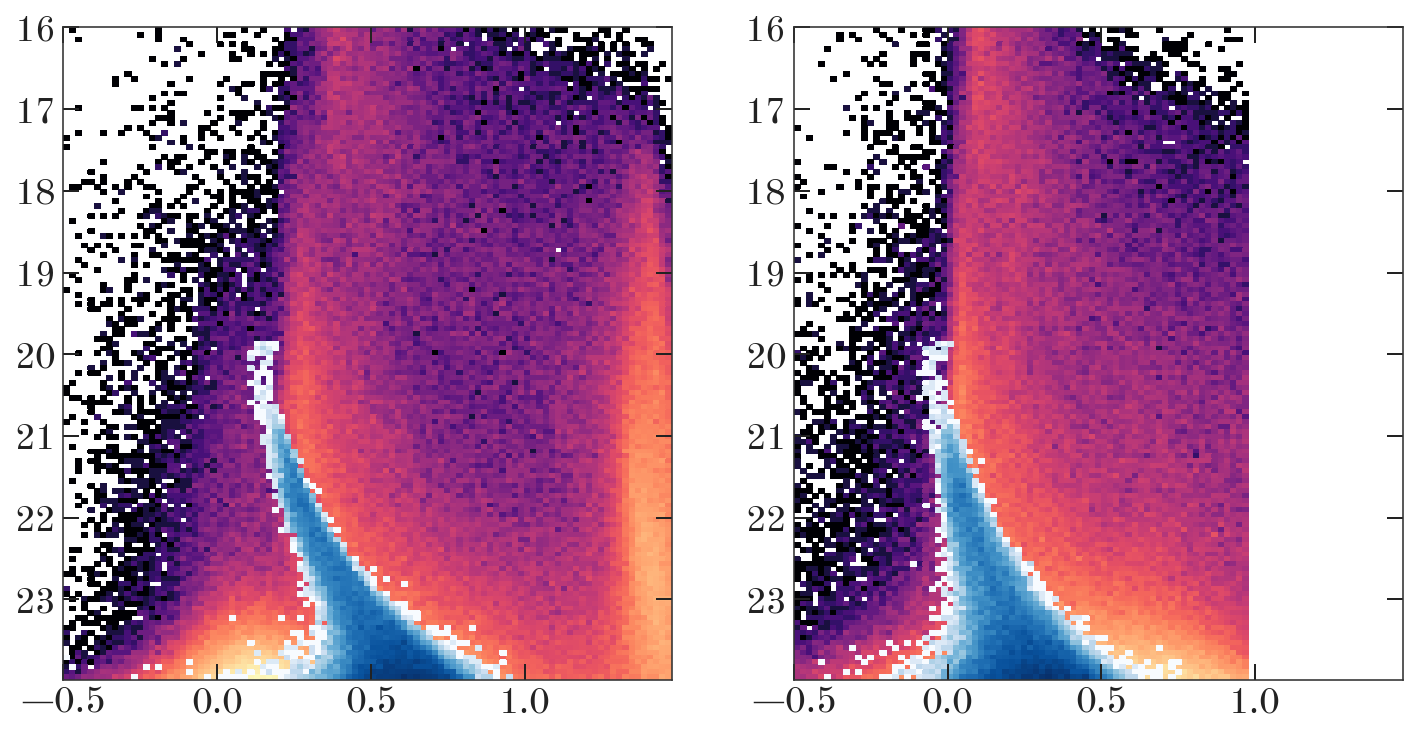

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.hist2d(gr, g,
          bins=(np.arange(-0.5, 1.5, 0.02),
                np.arange(16, 24+1e-3, 0.06)),
          norm=mpl.colors.LogNorm());

ax.hist2d(gr[sqdiff_mask], g[sqdiff_mask],
          bins=(np.arange(-0.5, 1.5, 0.02),
                np.arange(16, 24+1e-3, 0.06)),
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.set_ylim(ax.get_ylim()[::-1])

ax = axes[1]
ax.hist2d(rz, g,
          bins=(np.arange(-0.5, 1., 0.02),
                np.arange(16, 24+1e-3, 0.06)),
          norm=mpl.colors.LogNorm());

ax.hist2d(rz[sqdiff_mask], g[sqdiff_mask],
          bins=(np.arange(-0.5, 1.5, 0.02),
                np.arange(16, 24+1e-3, 0.06)),
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.set_ylim(ax.get_ylim()[::-1])

---

Simple isochrone filter:

(23.97999999999983, 16.0)

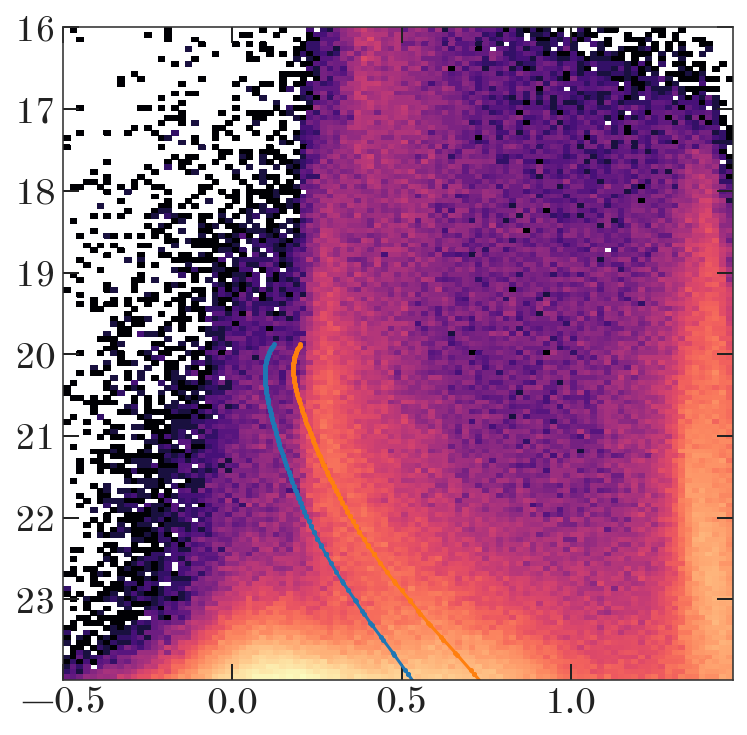

In [81]:
func = lambda x: 0.04 * (x/20)**5

iso_g = iso_grz[0] + dm
iso_X1 = np.stack((iso_grz[0] - iso_grz[1] - func(iso_g),
                   iso_g)).T
iso_X2 = np.stack((iso_grz[0] - iso_grz[1] + func(iso_g),
                   iso_g)).T

# ---

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.hist2d(gr, g,
          bins=(np.arange(-0.5, 1.5, 0.02),
                np.arange(16, 24+1e-3, 0.06)),
          norm=mpl.colors.LogNorm());

ax.plot(iso_X1[:, 0], iso_X1[:, 1])
ax.plot(iso_X2[:, 0], iso_X2[:, 1])

ax.set_ylim(ax.get_ylim()[::-1])

In [85]:
simple_mask = mpl.path.Path(np.vstack((iso_X1, iso_X2[::-1])))\
    .contains_points(np.stack((gr, g)).T)

(23.97999999999983, 16.0)

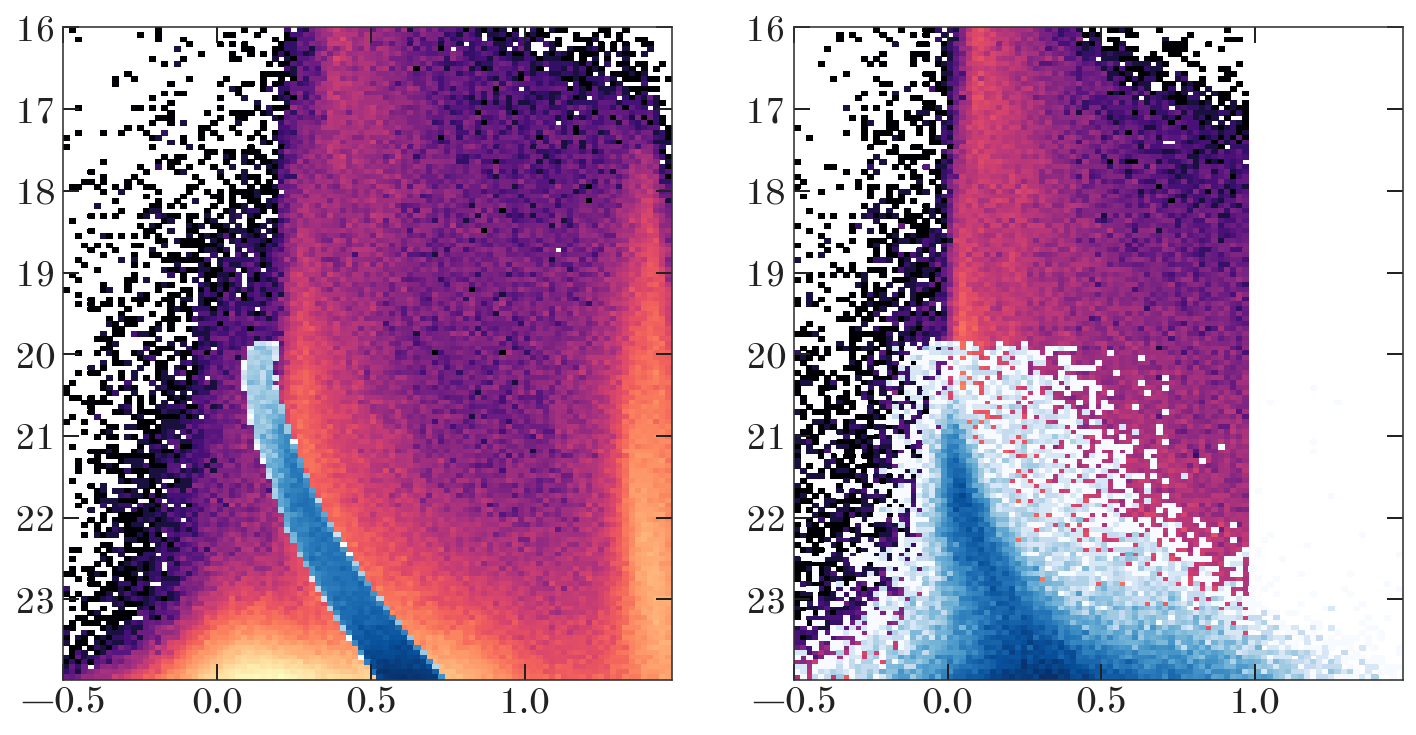

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.hist2d(gr, g,
          bins=(np.arange(-0.5, 1.5, 0.02),
                np.arange(16, 24+1e-3, 0.06)),
          norm=mpl.colors.LogNorm());

ax.hist2d(gr[simple_mask], g[simple_mask],
          bins=(np.arange(-0.5, 1.5, 0.02),
                np.arange(16, 24+1e-3, 0.06)),
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.set_ylim(ax.get_ylim()[::-1])

ax = axes[1]
ax.hist2d(rz, g,
          bins=(np.arange(-0.5, 1., 0.02),
                np.arange(16, 24+1e-3, 0.06)),
          norm=mpl.colors.LogNorm());

ax.hist2d(rz[simple_mask], g[simple_mask],
          bins=(np.arange(-0.5, 1.5, 0.02),
                np.arange(16, 24+1e-3, 0.06)),
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.set_ylim(ax.get_ylim()[::-1])

In [57]:
from scipy.ndimage import gaussian_filter

In [92]:
sqdiff_mask = (np.sqrt(sqdiff) < 2.)

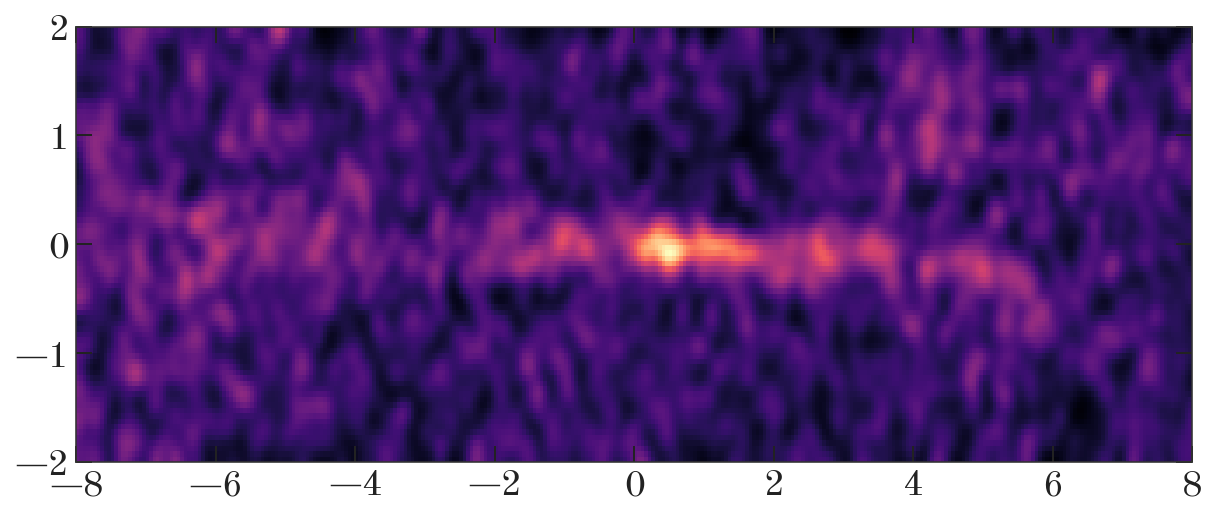

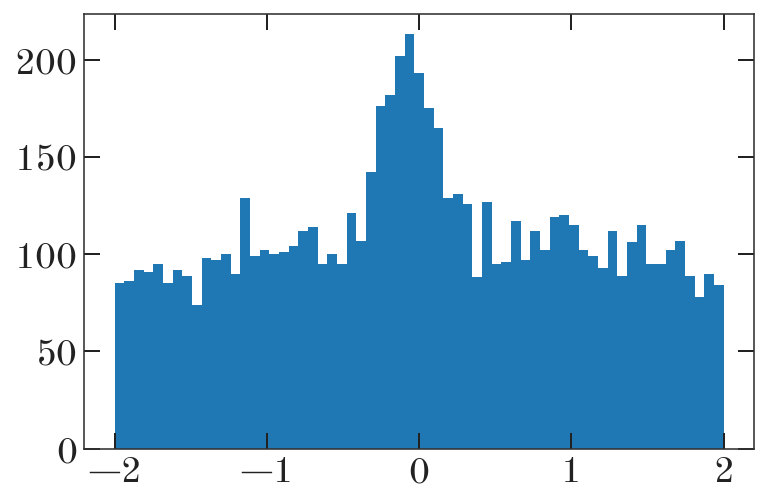

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
H, xe, ye = np.histogram2d(
    t_fr.phi1.degree[sqdiff_mask & (g < 23.2)], 
    t_fr.phi2.degree[sqdiff_mask & (g < 23.2)], 
    bins=(np.arange(-8, 8+1e-3, 0.05),
          np.arange(-2, 2+1e-3, 0.05)))

ax.pcolormesh(xe, ye, gaussian_filter(H, 2).T)

# ---

plt.figure()
plt.hist(t_fr.phi2.degree[sqdiff_mask & (g < 23.2)],
         bins=np.linspace(-2, 2, 64));

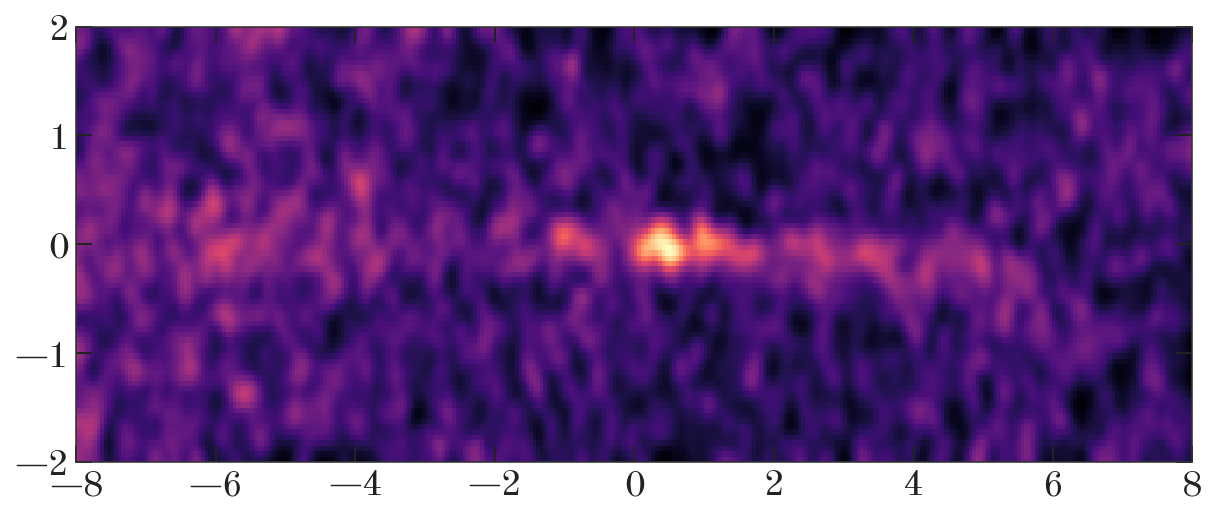

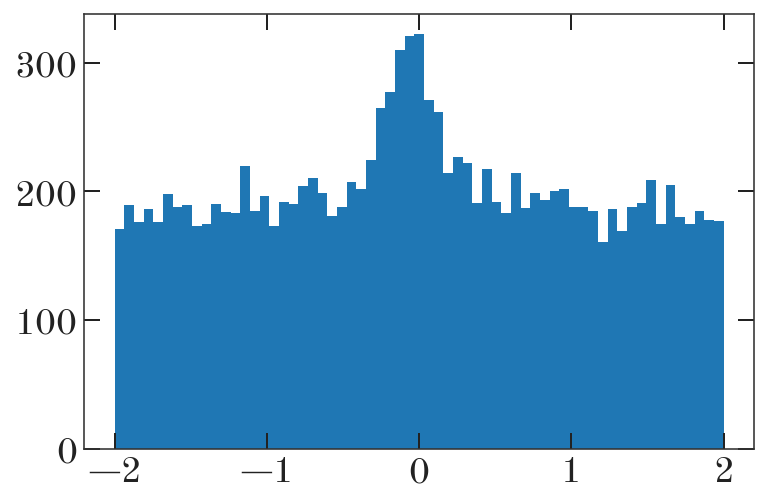

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
H, xe, ye = np.histogram2d(
    t_fr.phi1.degree[simple_mask & (g < 23.2)], 
    t_fr.phi2.degree[simple_mask & (g < 23.2)], 
    bins=(np.arange(-8, 8+1e-3, 0.05),
          np.arange(-2, 2+1e-3, 0.05)))

ax.pcolormesh(xe, ye, gaussian_filter(H, 2).T)

# ---
plt.figure()
plt.hist(t_fr.phi2.degree[simple_mask & (g < 23.2)],
         bins=np.linspace(-2, 2, 64));